In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.11.1
numpy   1.19.5
pandas  1.1.4



In [2]:
from skbio.stats.composition import clr, clr_inv

from multiplicative_replacement import multiplicative_replacement

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/skbio/sequence/_sequence.py:28: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  collections.Sequence, SkbioObject):
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/skbio/io/format/gff3.py:217: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [3]:
import csv

def get_taxamap(inf_path) -> dict:
    taxa_map = dict()
    with open(inf_path) as inf:
        csv_reader = csv.reader(inf, delimiter="\t")
        for row in csv_reader:
            taxa_map[row[0]] = row[1]
    return taxa_map

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
taxamap = get_taxamap("/mnt/btrfs/data/shogun/gtdb_95/r95.gtdb.tax")
reverse_taxamap = dict(zip(taxamap.values(), taxamap.keys()))

In [5]:
df_no_gcf = pd.read_csv("../data/no_gcf_otu_taxatable/species.gtdb98.normalized.txt", sep="\t")

df_no_gcf["#OTU ID"] = df_no_gcf["#OTU ID"].map(reverse_taxamap)
df_no_gcf = df_no_gcf.rename({"#OTU ID": "#OTU ID"}, axis=1)

df_no_gcf.set_index("#OTU ID", inplace=True)
# df_no_gcf_clr = pd.DataFrame(np.transpose(clr(multiplicative_replacement(df_no_gcf.T.values))), index=df_no_gcf.index, columns=df_no_gcf.columns)

In [6]:
df_no_gcf = df_no_gcf.apply(lambda x: x / x.sum(), axis=0)

In [7]:
df_gcf = pd.read_csv("../data/otu_taxatable/species.gtdb98.normalized.txt", sep="\t")

df_gcf["#OTU ID"] = df_gcf["#OTU ID"].map(reverse_taxamap)
df_gcf = df_gcf.rename({"#OTU ID": "#OTU ID"}, axis=1)

df_gcf.set_index("#OTU ID", inplace=True)
# df_gcf_clr = pd.DataFrame(np.transpose(clr(multiplicative_replacement(df_gcf.T.values))), index=df_gcf.index, columns=df_gcf.columns)

In [8]:
df_gcf = df_gcf.apply(lambda x: x / x.sum(), axis=0)

In [9]:
df_tax_splines = pd.read_csv("../results/tax_clr_splines.csv", index_col=0)

In [10]:
df_features = pd.read_csv("/mnt/btrfs/data/shogun/gtdb_95_type_1/db_features.fixed.extra.csv", index_col=0)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (54,67,68,72,79,80,81,84,87,88,89,90,92,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
df_gcf_clr_merged = pd.merge(df_no_gcf - df_gcf, df_features[["assembly_accession", "ungapped_genome_length"]], left_on="#OTU ID", right_on="assembly_accession", how="left")

In [12]:
# df_gcf_clr_merged["ungapped_genome_length"] = clr(df_gcf_clr_merged["ungapped_genome_length"])

In [13]:
ids = [col for col in df_gcf_clr_merged.columns if col.startswith("MCT")]

In [14]:
df_tall_gcf_clr_merged = pd.melt(df_gcf_clr_merged, id_vars=["ungapped_genome_length"], value_vars=ids)

In [15]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [16]:
prestige_model = ols("value ~ ungapped_genome_length", data=df_tall_gcf_clr_merged).fit()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print(prestige_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     7557.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:21:17   Log-Likelihood:             8.8695e+05
No. Observations:              201994   AIC:                        -1.774e+06
Df Residuals:                  201992   BIC:                        -1.774e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


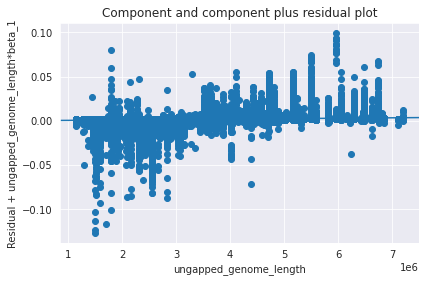

In [18]:
fig = sm.graphics.plot_ccpr(prestige_model, "ungapped_genome_length")
fig.tight_layout(pad=1.0)